In [1]:
import matplotlib.pyplot as plt
from itertools import combinations, permutations, product
from typing import Dict, Tuple, List, Any, NamedTuple, Callable
import jax
import jax.numpy as jnp
# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())
from jax import Array
from jax import jit
import jax.numpy as jnp
import ase.calculators.calculator as ase_calc
import sys
import e3x
import jax
import numpy as np
import optax
import orbax
from pathlib import Path
import pandas as pd
import os
# # Add custom path
sys.path.append("/home/boittier/github/JaxPychamm")
import physnetjax
# MMML
from mmml.pycharmmInterface.import_pycharmm import *
from mmml.pycharmmInterface import setupRes
from physnetjax.analysis.analysis import *
from physnetjax.analysis.povray_tool import *
pycharmm_quiet()

from mmml.generate.dimers import (
    make_rigid_angle_scan, make_rigid_com_scan, make_rotations, get_mean_plane, angle_between_planes, com_dist)
# from mmml.generate.descriptors import com_dist










resid = "CPEN"
reset_block()
res_atoms = setupRes.main(resid)
reset_block()
res_atoms = setupRes.main(resid)

[CudaDevice(id=0), CudaDevice(id=1)]
gpu
[CudaDevice(id=0), CudaDevice(id=1)]
/home/boittier/mmml/mmml/data/top_all36_cgenff.rtf
/home/boittier/mmml/mmml/data/par_all36_cgenff.prm
CHARMM_HOME /home/boittier/mmml/setup/charmm
CHARMM_LIB_DIR /home/boittier/mmml/setup/charmm
  
 CHARMM>     BLOCK
 WARNING from DECODI -- Zero length string being converted to 0
 Block structure initialized with   3 blocks.
 All atoms have been assigned to block 1.
 All interaction coefficients have been set to unity.
  Setting number of block exclusions nblock_excldPairs=0
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of 

In [87]:
"""Generates a residue from the RTF file"""
print("*" * 5, "Generating residue", "*" * 5)
s = """DELETE ATOM SELE ALL END"""
pycharmm.lingo.charmm_script(s)
read.rtf(CGENFF_RTF)
bl = settings.set_bomb_level(-2)
wl = settings.set_warn_level(-2)
read.prm(CGENFF_PRM)
settings.set_bomb_level(bl)
settings.set_warn_level(wl)
pycharmm.lingo.charmm_script("bomlev 0")
read.sequence_string(f"{resid} {resid}")
gen.new_segment(seg_name="DIMI", setup_ic=True)
R = np.concatenate(
    [res_atoms.get_positions() , (res_atoms.get_positions() + np.array([0,0,4]))]
)
_ = coor.get_positions()
_["x"] = R[:,0]
_["y"] = R[:,1]
_["z"] = R[:,2]
coor.set_positions(_)
reset_block()
setupRes.mini(nbxmod=1)
setupRes.mini(nbxmod=5)


***** Generating residue *****

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
***** Minimizing *****
***** Minimizing *****


In [88]:
view_pycharmm_state()

In [179]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

def reorder_points(P, Q):
    """
    Match points from Q to P using the Hungarian algorithm.
    Returns Q reordered to best match P.
    """
    distance_matrix = cdist(P, Q)  # shape (N, N)
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    return Q[col_ind]




In [180]:
state_atoms = ase_from_pycharmm_state()
A = state_atoms[:15]
B = state_atoms[15:]
A,B

(Atoms(symbols='CH2CH2CH2CH2CH2', pbc=False),
 Atoms(symbols='CH2CH2CH2CH2CH2', pbc=False))

In [181]:
view_atoms(A)

In [182]:
fn = "test.xyz"
ase.io.write(fn, A)

In [183]:
test_pos = np.array([A.get_positions(), A.get_positions()]).reshape(-1,3)
test_Z = np.array([A.get_atomic_numbers(), A.get_atomic_numbers()]).reshape(-1)
test_pos 

array([[ 1.49706864,  1.30009002, -0.17176636],
       [ 2.52601212,  1.34258833,  0.20710863],
       [ 1.15341708,  2.34083617, -0.28679695],
       [ 1.37375654,  0.56010616, -1.5083934 ],
       [ 1.96218268, -0.37118591, -1.47353854],
       [ 1.74587331,  1.14010798, -2.36158122],
       [-0.12244953,  0.22789065, -1.60874376],
       [-0.31506062, -0.66395006, -2.21819875],
       [-0.65679645,  1.05982533, -2.09693386],
       [-0.61782827,  0.07718754, -0.15504782],
       [-0.91195427, -0.95844519,  0.07003716],
       [-1.51385753,  0.69546377,  0.00982836],
       [ 0.54267426,  0.53254814,  0.75146248],
       [ 1.05853979, -0.35137136,  1.16309718],
       [ 0.20800473,  1.12593603,  1.61038472],
       [ 1.49706864,  1.30009002, -0.17176636],
       [ 2.52601212,  1.34258833,  0.20710863],
       [ 1.15341708,  2.34083617, -0.28679695],
       [ 1.37375654,  0.56010616, -1.5083934 ],
       [ 1.96218268, -0.37118591, -1.47353854],
       [ 1.74587331,  1.14010798, -2.361

In [184]:
# test_pos[15:] = test_pos.mean(axis=0) + 10
# test_pos

In [185]:
_ = ase.Atoms(test_Z.flatten(), test_pos)
view_atoms(_)

In [198]:
_ = min_confs["D2"][0][0]
confs_test = _.get_positions()
view_atoms(_)


In [213]:
reordered = reorder_atoms(_, A)
view_atoms(reordered)

Post-alignment RMSD: 2.079852799248962
Post-alignment RMSD: 2.4003623042121034


In [253]:
from mmml.generate.dimers import separate_monomers_by_distance
# Optional: align (should be almost identity if just shuffled)
from numpy.linalg import norm


def reorder_atoms(atoms, A):
    monoA_, monoB_ = separate_monomers_by_distance(atoms)
    
    Z = A.get_atomic_numbers()
    monomers = []
    for monoA in [monoA_, monoB_]:
        Za = monoA.get_atomic_numbers()
        P = np.array([[z, *xyz] for z, xyz in zip(Z, A.get_positions())])
        Q = np.array([[z, *xyz] for z, xyz in zip(Za, monoA.get_positions())])
        # Q = np.array([] + [monoA.get_positions()])
        Q_reordered = reorder_points(P, Q)
        aligned_Q, R = kabsch(Q_reordered, P)
        print("Post-alignment RMSD:", np.sqrt(np.mean(np.sum((aligned_Q - (P - P.mean(0)))**2, axis=1))))
        resA = ase.Atoms(Z, Q_reordered[:,1:])
        monomers.append(resA)
    return monomers[0] + monomers[1]
    # view_atoms(res)

In [254]:
from mmml.generate.dimers import generate_from_crystal_syms

min_confs = generate_from_crystal_syms(fn)

In [255]:
[len(min_confs[k]) for k in min_confs.keys()]

[20, 6, 6, 10, 4]

In [256]:
min_confs.keys()

dict_keys(['C1', 'Ci', 'C2', 'Cs', 'D2'])

In [257]:
view_atoms(min_confs["D2"][0][0])

In [258]:
dir(min_confs["D2"][0][0])

['__add__',
 '__ase_optimizable__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ase_handles_dynamic_stress',
 '_calc',
 '_celldisp',
 '_cellobj',
 '_centering_as_array',
 '_constraints',
 '_del_constraints',
 '_get_atomic_numbers',
 '_get_constraints',
 '_get_positions',
 '_masked_rotate',
 '_pbc',
 '_set_positions',
 'append',
 'arrays',
 'ase_objtype',
 'calc',
 'cell',
 'center',
 'constraints',
 'copy',
 'edit',
 'euler_rotate',
 'extend',
 'fromdict',
 'get_all_distances',
 'get_angle',
 'get_angles',
 'get_angular_momentum',
 'get_array',
 'get_at

In [259]:
min_confs["D2"][0][0].numbers

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6])

In [260]:
all_atoms = make_rotations(A, B, distance = 8)

In [261]:
len(all_atoms)

450

In [262]:
all_atoms[0]

Atoms(symbols='CH2CH2CH2CH2CH2CH2CH2CH2CH2CH2', pbc=False)

In [263]:
min_confs["C1"][0][0]

Atoms(symbols='H20C10', pbc=[False, False, True], cell=[[22.539832969729883, -1.2511912443288087, 1.3638693978244931], [0.0, 21.835221803370537, 6.149017892666821], [0.0, 0.0, 8.45096064324892]])

In [264]:
refA = state_atoms[:15]
refB = state_atoms[15:]
n_failed = 0
for k in min_confs.keys():
    for _ in min_confs[k]:
        try:
            _ = reorder_atoms(_[0], refA)
            set_pycharmm_xyz(_.get_positions())
            # setupRes.mini()
            _.set_positions(coor.get_positions().to_numpy())
            
            _R = _.get_positions()
            _R += ((np.random.normal(size=np.prod(_R.shape)).reshape(_R.shape))*0.01)
            _.set_positions(_R)
            A = _[:15]
            B = _[15:]
            for rotated in make_rotations(A, B, distance = 8):
                all_atoms.append(rotated)
        except ValueError as valEr:
            print(valEr)
            print(k, n_failed)
            n_failed += 1

not enough values to unpack (expected 2, got 1)
C1 0
Post-alignment RMSD: 1.3149219902694083
Post-alignment RMSD: 1.0500340516842737
Post-alignment RMSD: 1.9866936560266089
Post-alignment RMSD: 2.2408089938854836
Post-alignment RMSD: 2.3301416355418234
Post-alignment RMSD: 1.7916666788087805
Post-alignment RMSD: 1.7942793237562158
Post-alignment RMSD: 1.8849245906086067
Post-alignment RMSD: 2.4324139861000833
Post-alignment RMSD: 1.8425515460275665
Post-alignment RMSD: 2.3921367665213213
Post-alignment RMSD: 2.4755527693804087
Post-alignment RMSD: 1.4830257621432248
Post-alignment RMSD: 0.7443085756533143
Post-alignment RMSD: 1.1101801002100726
Post-alignment RMSD: 1.5764855584677957
Post-alignment RMSD: 1.624748459495155
Post-alignment RMSD: 2.327245394663747
not enough values to unpack (expected 2, got 1)
C1 1
not enough values to unpack (expected 2, got 1)
C1 2
Post-alignment RMSD: 1.7362771595494442
Post-alignment RMSD: 1.5035072277345878
not enough values to unpack (expected 2, go

In [265]:
# len(all_atoms)
view_pycharmm_state()

In [266]:
# view(all_atoms[-1])

In [267]:
all_atoms_data = []
for _ in all_atoms:
    set_pycharmm_xyz(_.get_positions())
    _data = energy.get_energy().to_dict()
    _data = {x:_data[x][0] for x in _data}

    c1,n1 = get_mean_plane(_[:15])
    c2,n2 = get_mean_plane(_[15:])
    theta1 = angle_between_planes(n1, n2)
    theta2 = angle_between_planes(c1, c2)
    com_r = com_dist(_,15)
    _data.update(
        {"$\\theta_1$": theta1,
         "$\\theta_2$": theta2,
         "$r$": com_r}
    )
    all_atoms_data.append(_data)

In [268]:
_ = pd.DataFrame(all_atoms_data)
_["NBOND"] = _ ["VDW"] + _["ELEC"]
_.keys()

Index(['ENER', 'GRMS', 'DELTA', 'BOND', 'ANGL', 'UREY', 'DIHE', 'IMPR', 'VDW',
       'ELEC', 'HBON', 'USER', 'HARM', 'CDIH', 'CIC', 'CDRO', 'NOE', 'SBOU',
       'IMNB', 'IMEL', 'IMHB', 'EWKS', 'EWSE', 'EXTE', 'RXNF', 'ST2', 'IMST',
       'TSM', 'QMEL', 'QMVD', 'ASP', 'EHAR', 'GEO', 'MDIP', 'PINT', 'PRMS',
       'PANG', 'SSBP', 'BK4D', 'SHEL', 'RESD', 'SHAP', 'STRB', 'OOPL', 'PULL',
       'POLA', 'DMC', 'RGY', 'EWEX', 'EWQC', 'EWUT', 'PBEL', 'PBNP', 'MBDE',
       'STRS', 'BNDB', 'BNDT', 'EBST', 'MBST', 'BBT', 'SST', 'GBEN', 'HMCM',
       '$\theta_1$', '$\theta_2$', '$r$', 'NBOND'],
      dtype='object')

In [269]:
_ = _[_["NBOND"] < 30]

In [270]:
_[["$\\theta_1$", "$\\theta_2$", "$r$", "VDW", "ELEC","NBOND"]]

,$\theta_1$,$\theta_2$,$r$,VDW,ELEC,NBOND
0,102.419519,18.477789,8.007784,-1.571213,1.257329,-0.313884
1,102.048060,18.499628,8.022780,-1.581812,1.320646,-0.261167
2,95.874432,18.505245,8.010693,-1.551172,1.285115,-0.266057
3,84.617498,18.489510,8.011623,-1.594228,1.120675,-0.473553
4,71.344251,18.483232,8.012067,-1.556980,1.139959,-0.417021
...,...,...,...,...,...,...
445,81.836071,18.458944,7.990891,-1.560793,1.163288,-0.397505
446,83.661335,18.434996,7.990375,-1.575404,1.220527,-0.354877
447,86.946929,18.416472,7.978165,-1.568231,1.250705,-0.317525
448,91.324669,18.445299,7.987046,-1.551724,1.235079,-0.316645


array([[<Axes: title={'center': '$\\theta_1$'}>,
        <Axes: title={'center': '$\\theta_2$'}>],
       [<Axes: title={'center': '$r$'}>, <Axes: title={'center': 'VDW'}>],
       [<Axes: title={'center': 'ELEC'}>,
        <Axes: title={'center': 'NBOND'}>]], dtype=object)

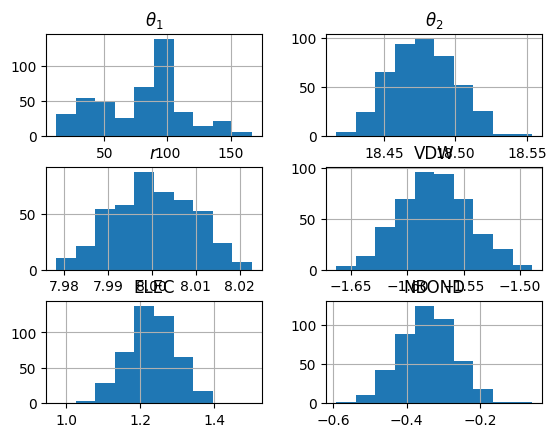

In [271]:
_[["$\\theta_1$", "$\\theta_2$", "$r$", "VDW", "ELEC","NBOND"]].hist()

In [272]:
_[["$\\theta_1$", "$\\theta_2$", "$r$", "VDW", "ELEC","NBOND"]].describe()

,$\theta_1$,$\theta_2$,$r$,VDW,ELEC,NBOND
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,80.582665,18.477374,8.000252,-1.575694,1.232012,-0.343681
std,34.798170,0.022349,0.009105,0.031100,0.067177,0.074786
min,11.746361,18.416472,7.978165,-1.663287,0.972135,-0.591759
25%,49.636071,18.460342,7.993519,-1.596138,1.190010,-0.389884
50%,88.189649,18.475902,7.999966,-1.576323,1.231293,-0.344904
75%,102.276940,18.492995,8.007068,-1.555424,1.275959,-0.293271
max,166.950142,18.553834,8.022780,-1.488904,1.501660,-0.058533


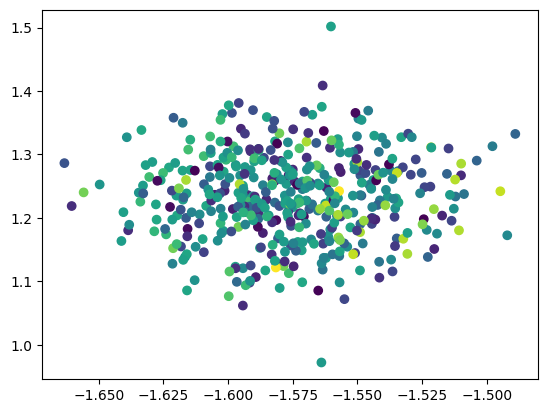

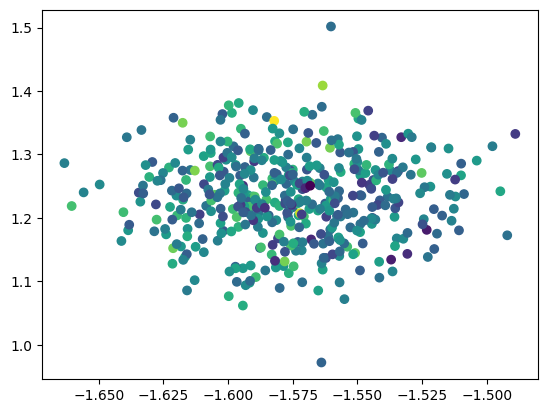

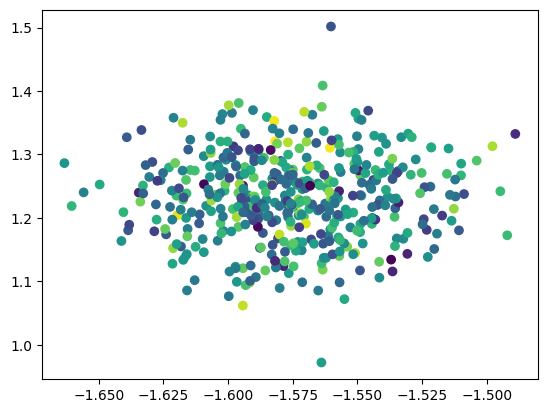

In [273]:
for k in ["$\\theta_1$", "$\\theta_2$", "$r$",]:
    plt.scatter(_ ["VDW"], _["ELEC"], c=_[k])
    plt.show()

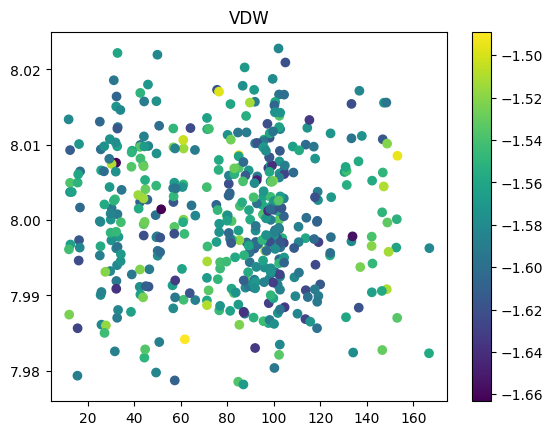

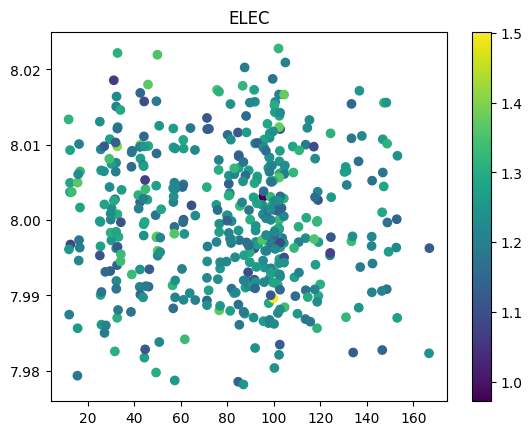

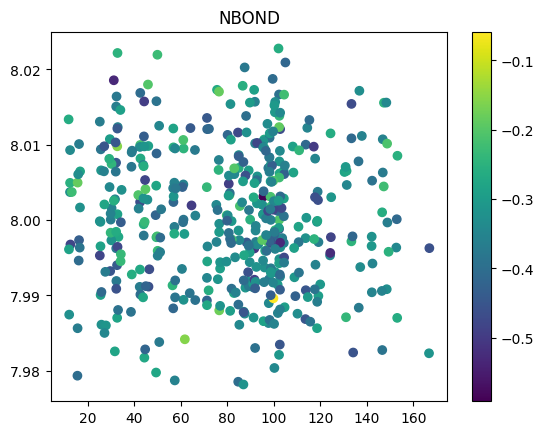

In [275]:
for k in ["VDW", "ELEC", "NBOND"]:
    s = plt.scatter(_ ["$\\theta_1$"],_ ["$r$"], c=_[k])
    plt.colorbar(s)
    plt.title(k)
    plt.show()

In [276]:
# Write them all to a single XYZ file as a trajectory
ase.io.write('trajectory.xyz', all_atoms)